1) Data is tif files stored in directory src/data/originals
2) Maps corresponding to the same region are stored in the same folder
3) Convert each of the maps to patches
4) Apply the alignment (use the oldest map as the reference map - the one with the smalles)
5) Format to feed to network (?)

### Imports

In [ ]:
import PIL
import os
import logging
import pickle as pk
from copy import deepcopy
from datetime import datetime
import time

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify,unpatchify
import cv2 as cv

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logging.basicConfig(format='%(asctime)s %(levelname)-4s %(message)s',
                    level=logging.INFO,
                    datefmt='%d-%m-%Y %H:%M:%S')

logging.getLogger("PIL").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

PIL.Image.MAX_IMAGE_PIXELS = 933120000

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.transforms import InterpolationMode
from skimage.measure import block_reduce
from torch.utils.data import Dataset,DataLoader

from torchvision.models.resnet import resnet50, ResNet50_Weights

import wandb

In [ ]:
torch.manual_seed(23)

### Class: MapPatch

In [ ]:
class MapPatch():
    def __init__(self, patch, patch_index, origin_map):
        self.patch = patch
        self.patch_index = patch_index
        self.origin_map = origin_map
        self.patch_shift = None
        
    @staticmethod
    def get_map_patches(file_name, patch_width, verbose = True):
        tif_map = PIL.Image.open(file_name)
        tif_map_np = np.array(tif_map)
        
        tif_map_patches = patchify(image = tif_map_np, 
                                   patch_size = (patch_width, patch_width, 3),
                                   step = patch_width)

        if verbose:
            logging.info(f"{np.prod(tif_map_patches.shape[:2]):,} patches from {file_name} generated with shape {tif_map_patches.shape}")

        return tif_map_np, tif_map_patches
    
    @staticmethod
    def get_map_patch_list(file_name, patch_width, verbose = True):
        _, tif_map_patches = MapPatch.get_map_patches(file_name, 
                                                      patch_width, 
                                                      verbose = verbose)
        
        patches = [MapPatch(tif_map_patches[i,j,0], patch_index = (i,j), origin_map = file_name)
                  for i in range(tif_map_patches.shape[0])
                  for j in range(tif_map_patches.shape[1])]
                
        return patches
    
    def get_map_px(self):
        """
        Gets location of the top left pixel of the patch in the original image.
        """
        patch_size = self.patch.shape[0]
        row = self.patch_index[0]
        col = self.patch_index[1]
        
        return (row * patch_size, col * patch_size)
    
    def show(self, verbose = True):
        """
        Shows the patch.
        """
        fig, ax = plt.subplots()
        ax.imshow(self.patch)
        
        if verbose:
            ax.set_title(f"Patch at {self.patch_index} from {self.origin_map}.")
            
        plt.show()

### Class: CLPatchDataset

In [ ]:
class CLPatchDataset(Dataset):
    def __init__(self, X_1, X_2):
        self.X_1 = X_1
        self.X_2 = X_2
    
    def __len__(self):
        return len(self.X_1)
    
    def __getitem__(self, i):
        
        if isinstance(i, slice):
            start = i.start if i.start else 0
            stop = i.stop if i.stop else len(self.patches)
            step = i.step if i.step else 1
            
            return [(self.X_1[j], self.X_2[j]) for j in range(start, stop, step)]
        
        return (self.X_1[i].patch, self.X_2[i].patch)
    
    @classmethod
    def from_dir(cls, map_directory, patch_width, verbose = False):
        X_1 = []
        X_2 = []

        for folder in os.listdir(map_directory):
            if folder.isdigit():
                if verbose:
                    logging.info(f"Fetching patches from folder: {folder}")
                    
                directory = os.path.join(map_directory, folder)
                patch_list = CLPatchDataset.get_patch_list_from_dir(directory, patch_width = patch_width, verbose = False)
                x_1, x_2 = CLPatchDataset.get_matching_patch_list(patch_list)
                X_1.extend(x_1)
                X_2.extend(x_2)
            
        return cls(X_1, X_2)
    
    @staticmethod
    def index_sampler(indices, n_samples = 4):
        return [indices[i] for i in np.random.choice(len(indices), n_samples, replace=False)]

    @staticmethod
    def get_patch_list_from_dir(directory, patch_width, verbose = False):
        patches = []

        for file in os.listdir(directory):
            if file.endswith("tif"):
                file_name = f"{directory}/{file}"
                patches.append(MapPatch.get_map_patch_list(file_name = file_name, 
                                                           patch_width = patch_width, 
                                                           verbose = verbose))

        return patches
    
    @staticmethod
    def is_empty_patch(patch):
        gray = cv.cvtColor(np.array(patch), cv.COLOR_RGB2GRAY)
        gray = cv.GaussianBlur(gray, (3,3), 0)
        edges = cv.Canny(gray, 50, 150)
        black_pixels = np.where(edges == 255)

        return len(black_pixels[0]) <= 20
    
    @staticmethod
    def get_matching_patch_list(patch_list):
        n_samples = len(patch_list)
        indices = [(i,j) for i in range(n_samples) for j in range(i) if i != j]

        x_1 = []
        x_2 = []

        for i in range(len(patch_list[0])):
            #sample_indices = CLPatchDataset.index_sampler(indices, n_samples)
            sample_indices = [(i,i+1) for i in range(n_samples-1)]
            for index in sample_indices:
                try:
                    patch_1 = patch_list[index[0]][i]
                    patch_2 = patch_list[index[1]][i]
                    if not CLPatchDataset.is_empty_patch(patch_1.patch) and not CLPatchDataset.is_empty_patch(patch_2.patch):
                        x_1.append(patch_1)
                        x_2.append(patch_2)
                except IndexError:
                    print(f"Faulty generated index: {index}")
                    print(f"Index i: {i}")
                    print(f"len(patch_list): {len(patch_list)}")
                    print(f"len(patch_list[index[0]]): {len(patch_list[index[0]])}")
                    print(f"len(patch_list[index[1]]): {len(patch_list[index[1]])}")
                    raise ValueError()

        return x_1, x_2
    
    def save(self, file_name):
        with open(f"{file_name}.pk", "wb") as f:
            pk.dump(self, f)

In [ ]:
cl_patch_dataset = CLPatchDataset.from_dir("../src/data/originals/", 64, verbose = True)

In [ ]:
cl_patch_dataset.save("../src/data/originals/patch_dataset")

### Utility Classes for NNs

#### Class: MLP

In [ ]:
class MLP(nn.Module):
    """
    Class encoding a simple multi-layer perceptron, used for encoding and prediction.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, activation = nn.ReLU(), use_bias = True, use_batch_norm = True):
        """
        input_dim: an int, indicating the input dimension for the MLP.
        hidden_dim: an int, indicating the hidden dimension for the MLP.
        output_dim: an int, indicating the output dimension for the MLP.
        activation: a Pytorch activation (from the nn module), providing the non-linearity for the MLP.
        use_bias: a boolean. If true, the linear layers will use a bias weight.
        use_batch_norm: a boolean. If true, applies batch normalisation after the hidden layer.
        """
        super(MLP, self).__init__()
        
        # network layers for the projection head
        self.lin_hidden = nn.Linear(in_features = input_dim, 
                                    out_features = hidden_dim, 
                                    bias = use_bias)
        self.batch_norm = nn.BatchNorm1d(num_features = hidden_dim) if use_batch_norm else nn.Identity()
        self.activation = activation
        self.lin_output = nn.Linear(in_features = hidden_dim, 
                                    out_features = output_dim, 
                                    bias = use_bias)
        
        # define the model
        self.mlp = nn.Sequential(
                self.lin_hidden,
                self.batch_norm,
                self.activation,
                self.lin_output
                )
        
    def forward(self, x):
        """
        A forward pass through the MLP.
        """
        return self.mlp(x)

#### Class: Hook

In [ ]:
# based on the Hook class by Kennethborup:
# https://github.com/Kennethborup/BYOL
class Hook():
    """
    A simple hook class that returns the output of a layer of a model during forward pass.
    """
    def __init__(self):
        self.output = None
        
    def set_hook(self, module):
        """
        Attaches hook to model.
        """
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, _, output):
        """
        Saves the wanted information.
        """
        self.output = output

#### Class: EncoderProjectorNN

In [ ]:
class EncoderProjectorNN(nn.Module):
    """
    Class for a network which encodes an input and projects it into a latent space.
    """
    def __init__(self, encoder, projector, encoder_layer_idx = -1):
        """
        encoder: a nn.Module, containing an encoder network.
        projector: a nn.Module, containing a projector network.
        encoder_layer_idx: an int, corresponding to the index of the layer of the encoder 
                           which is actually used for encoding.
                           For instance, in BYOL, if using a ResNet as an encoder, 
                           the paper uses the output of the last average pooliing layer, 
                           which is the penultimate layer of the ResNet 
                           (corresponding to encoder_layer_idx = -2).
        """
        super(EncoderProjectorNN, self).__init__()
        
        self.encoder = encoder
        self.projector = projector
        self.encoder_layer_idx = encoder_layer_idx
        
        # if the encoding layer isn't the last one, add a hook to save the output of the layer
        if self.encoder_layer_idx != -1:
            self.hook = Hook()
            layers = [*self.encoder.children()]
            encoder_layer = layers[self.encoder_layer_idx]
            self.hook.set_hook(encoder_layer)
            
    def encode(self, x):
        """
        Encodes an input x, according to the encoder network and self.encoder_layer_idx.
        """
        
        encoded = self.encoder(x)
        
        if self.encoder_layer_idx != -1:
            # need to fix the output to remove the additional dimensions
            # for instance, images sent as 4-dimensional input (N,C,W,H) will remain 4 dimensional 
            # after passing through the encoder, and rely on final layers to reduce this to
            # 2 dimensions (N,X). 
            # Thus, if self.encoder_layer_idx != -1, we are missing this dimensionality reduction step, 
            # so we need to compensate for it.
            encoded = self.hook.output.reshape(encoded.shape[0],-1)
            
        return encoded
    
    def project(self, x):
        """
        Projects an input x into latent space, according to the projector network.
        """
        return self.projector(x)
    
    def forward(self, x):
        """
        A forward pass through the model, involving first encoding and then projecting.
        """
        encode_x = self.encode(x)
        return self.project(encode_x)

### Class: SIMCLR

In [ ]:
class MapSIMCLR(nn.Module):
    def __init__(self):
        super(MapSIMCLR, self).__init__()
        
        # model hyperparameters
        self.MAX_PIXEL_VALUE = 255
        self.RESNET_DIM = 224
        self.RESNET_OUTPUT_DIM = 1000
        self.HIDDEN_DIM = 1500
        self.OUTPUT_DIM = 100
        
        # resnet for encoding input images
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # network layers for the projection head
        self.lin_hidden = nn.Linear(in_features=self.RESNET_OUTPUT_DIM, out_features=self.HIDDEN_DIM, bias = False)
        self.batch_norm = nn.BatchNorm1d(num_features = self.HIDDEN_DIM)
        self.relu = nn.ReLU()
        self.lin_output = nn.Linear(in_features = self.HIDDEN_DIM, out_features = self.OUTPUT_DIM, bias = False)
        
        # define the model
        self.model = nn.Sequential(
                self.resnet,
                self.lin_hidden,
                self.batch_norm,
                self.relu,
                self.lin_output
                )
        
        # define optimiser
        self.optimiser = None

        # get the device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # create checkpoint
        self.checkpoint = {"epoch" : 0,
                           "batch" : 0,
                           "model_state_dict" : self.state_dict(),
                           "optimiser_state_dict": None,
                           "loss" : 0,
                           "avg_loss_20" : 0,
                           "run_start" : datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
                           "run_end" : None}
    
    def img_to_resnet(self, img, dim = None):
        """
        Convert image into the desired format for ResNet.
        The image must have width and height of at least self.RESNET_DIM, with RGB values between 0 and 1.
        Moreover, it must be normalised, by using a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225]
        --------------------------------------------------------------------------------------------------------------------------------
        :param img: a numpy nd.array, with 3 colour channels (this must be stored in the last dimensions), which has to be fed to ResNet
        :param dim: the desired dimension of the image (if we want to resize img before feeding it to ResNet).
                    This should be at least self.RESTNET_DIM.
        --------------------------------------------------------------------------------------------------------------------------------
        :return a Tensor, with the first dimension corresponding to the RGB channels, and normalised to be used by ResNet.
        """
        
        # put the colour channel in front and normalise into range [0,1]
        if len(img.shape) == 3:
            norm_img = torch.moveaxis(img, -1, 0)/self.MAX_PIXEL_VALUE
        else:
            norm_img = torch.moveaxis(img, -1, 1)/self.MAX_PIXEL_VALUE
        
        # resize
        if dim is not None:
            assert dim >= self.RESNET_DIM, f"Provided dimension {dim} is less than the required for RESNET ({self.RESNET_DIM})"
            norm_img = T.Resize(dim)(norm_img)  
        else:
            norm_img = T.Resize(self.RESNET_DIM)(norm_img)
        
        # normalise mean and variance
        mean = torch.Tensor([0.485, 0.456, 0.406])
        std = torch.Tensor([0.229, 0.224, 0.225])
        
        return T.Normalize(mean = mean, std = std)(norm_img)
    
    def contrastive_loss(self, z_batch, tau):
        """
        Computes the contrastive loss (NT-XENT) for a mini-batch of augmented samples.
        --------------------------------------------------------------------------------------------------------
        z_batch: a (N,K) Tensor, with rows as embedding vectors. 
                 We expect that z_batch[2k] and z_batch[2k+1], 0 <= k < N, correspond to a positive sample pair
        tau: temperature parameter for NT-XENT loss
        --------------------------------------------------------------------------------------------------------
        return: a float, corresponding to the total loss for the mini-batch z_batch
        """
        N = len(z_batch)

        # normalise to have unit length rows
        norm_z_batch = F.normalize(z_batch)

        # compute similarity & apply factor of tau
        sim_batch = (norm_z_batch @ norm_z_batch.T)/tau

        # fill the diagonal with -1000, to make sure it is never considered in the cross entropy computations
        sim_batch.fill_diagonal_(-1000)

        # generate labels
        # z_batch[2k] should be similar to z_batch[2k+1] (since these will be the positive pair)
        # hence, labels should have the form [1,0,3,2,...,N,N-1]
        labels = torch.Tensor([k+1 if k%2 == 0 else k-1 for k in range(0,N)]).long().to(self.device)

        # return the NT-XENT loss
        return 1/N * F.cross_entropy(sim_batch, labels, reduction = "sum")
    
    def forward(self, x):
        """
        A forward pass through the network
        """
        res_x = self.img_to_resnet(x)
        
        return self.model(res_x)
        
    
    def compile_optimiser(self, **kwargs):
        """
        Sets the optimiser parameters.
        """
        self.optimiser = optim.Adam(self.parameters(), **kwargs)
        
    def update_checkpoint(self, **checkpoint_data):
        """
        Updates the checkpoint dictionary.
        """
        for k,v in checkpoint_data:
            if k in self.checkpoint:
                self.checkpoint[k] = v
    
    def train(self, dataloader, tau, epochs):
        """
        Trains the network.
        """

        self.to(self.device)

        for epoch in range(epochs):
            batch_losses = []
            for batch, (x_1,x_2) in enumerate(dataloader):
                # x_1 and x_2 are tensors containing patches, 
                # such that x_1[i] and x_2[i] are patches for the same area
                
                self.optimiser.zero_grad()

                x_1, x_2 = x_1.to(self.device), x_2.to(self.device)
                
                z_1 = self(x_1)
                z_2 = self(x_2)
                
                z_batch = torch.stack((z_1,z_2), dim = 1).view(-1, self.OUTPUT_DIM)
                loss = self.contrastive_loss(z_batch, tau = tau)

                batch_losses.append(loss.cpu())
                
                loss.backward()
                self.optimiser.step()

                if batch % (len(dataloader) // 100 + 1) == 0:
                    with torch.no_grad():
                        avg_loss = np.mean(batch_losses[-20:])
                        print(f"Epoch {epoch + 1}: [{batch + 1}/{len(dataloader)}] ---- NT-XENT = {avg_loss}")
                        
                        self.update_checkpoint(epoch = epoch,
                                   batch = batch,
                                   model_state_dict = self.state_dict(),
                                   optimiser_state_dict = self.optimiser.state_dict,
                                   loss = loss.cpu(),
                                   avg_loss_20 = avg_loss,
                                   run_end = datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
                
        with torch.no_grad():
            self.update_checkpoint(epoch = epochs,
                                   batch = len(dataloader),
                                   model_state_dict = self.state_dict(),
                                   optimiser_state_dict = self.optimiser.state_dict,
                                   loss = loss.cpu(),
                                   avg_loss_20 = np.mean(batch_losses[-20:]),
                                   run_end = datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
        
        return self.checkpoint
                        

In [ ]:
class MapSIMCLR(nn.Module):
    def __init__(self, encoder, encoder_layer_idx, projector_parameters, tau):
        """
        tau: temperature parameter for NT-XENT loss
        """
        super(MapSIMCLR, self).__init__()
        
        # model constants
        self.MAX_PIXEL_VALUE = 255
        self.RESNET_DIM = 224
        
        # define the model
        self.model = EncoderProjectorNN(encoder = encoder,
                                        projector = MLP(**projector_parameters),
                                        encoder_layer_idx = encoder_layer_idx)
        
        self.tau = tau
        
        # define optimiser
        self.optimiser = None

        # get the device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # create checkpoint
        self.checkpoint = {"epoch" : 0,
                           "batch" : 0,
                           "model_state_dict" : self.state_dict(),
                           "optimiser_state_dict": None,
                           "loss" : 0,
                           "avg_loss_20" : 0,
                           "run_start" : datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
                           "run_end" : None}
    
    def img_to_resnet(self, img, dim = None):
        """
        Convert image into the desired format for ResNet.
        The image must have width and height of at least self.RESNET_DIM, with RGB values between 0 and 1.
        Moreover, it must be normalised, by using a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225]
        --------------------------------------------------------------------------------------------------------------------------------
        :param img: a numpy nd.array, with 3 colour channels (this must be stored in the last dimensions), which has to be fed to ResNet
        :param dim: the desired dimension of the image (if we want to resize img before feeding it to ResNet).
                    This should be at least self.RESTNET_DIM.
        --------------------------------------------------------------------------------------------------------------------------------
        :return a Tensor, with the first dimension corresponding to the RGB channels, and normalised to be used by ResNet.
        """
        
        # put the colour channel in front and normalise into range [0,1]
        if len(img.shape) == 3:
            norm_img = torch.moveaxis(img, -1, 0)/self.MAX_PIXEL_VALUE
        else:
            norm_img = torch.moveaxis(img, -1, 1)/self.MAX_PIXEL_VALUE
        
        # resize
        if dim is not None:
            assert dim >= self.RESNET_DIM, f"Provided dimension {dim} is less than the required for RESNET ({self.RESNET_DIM})"
            norm_img = T.Resize(dim)(norm_img)  
        else:
            norm_img = T.Resize(self.RESNET_DIM)(norm_img)
        
        # normalise mean and variance
        mean = torch.Tensor([0.485, 0.456, 0.406])
        std = torch.Tensor([0.229, 0.224, 0.225])
        
        return T.Normalize(mean = mean, std = std)(norm_img)
    
    def contrastive_loss(self, z_batch):
        """
        Computes the contrastive loss (NT-XENT) for a mini-batch of augmented samples.
        --------------------------------------------------------------------------------------------------------
        z_batch: a (N,K) Tensor, with rows as embedding vectors. 
                 We expect that z_batch[2k] and z_batch[2k+1], 0 <= k < N, correspond to a positive sample pair
        --------------------------------------------------------------------------------------------------------
        return: a float, corresponding to the total loss for the mini-batch z_batch
        """
        N = len(z_batch)

        # normalise to have unit length rows
        norm_z_batch = F.normalize(z_batch)

        # compute similarity & apply factor of tau
        sim_batch = (norm_z_batch @ norm_z_batch.T)/self.tau

        # fill the diagonal with -1000, to make sure it is never considered in the cross entropy computations
        sim_batch.fill_diagonal_(-1000)

        # generate labels
        # z_batch[2k] should be similar to z_batch[2k+1] (since these will be the positive pair)
        # hence, labels should have the form [1,0,3,2,...,N,N-1]
        labels = torch.Tensor([k+1 if k%2 == 0 else k-1 for k in range(0,N)]).long().to(self.device)

        # return the NT-XENT loss
        return 1/N * F.cross_entropy(sim_batch, labels, reduction = "sum")
    
    def forward(self, x):
        """
        A forward pass through the network
        """
        
        if x.shape[:2] != (self.RESNET_DIM, self.RESNET_DIM):
            x = self.img_to_resnet(x)
            
        return self.model.encode(x)
        
    
    def compile_optimiser(self, **kwargs):
        """
        Sets the optimiser parameters.
        """
        self.optimiser = optim.Adam(self.parameters(), **kwargs)
        
    def update_checkpoint(self, **checkpoint_data):
        """
        Updates the checkpoint dictionary.
        """
        for k,v in checkpoint_data:
            if k in self.checkpoint:
                self.checkpoint[k] = v
    
    def train(self, dataloader, epochs, transform = None):
        """
        Trains the network.
        """

        self.to(self.device)

        for epoch in range(epochs):
            batch_losses = []
            for batch, (x_1,x_2) in enumerate(dataloader):
                # x_1 and x_2 are tensors containing patches, 
                # such that x_1[i] and x_2[i] are patches for the same area
                
                self.optimiser.zero_grad()

                x_1, x_2 = transform(x_1.to(self.device)), transform(x_2.to(self.device))
                
                z_1 = self.model(x_1)
                z_2 = self.model(x_2)
                
                z_batch = torch.stack((z_1,z_2), dim = 1).view(-1, self.OUTPUT_DIM)
                loss = self.contrastive_loss(z_batch, tau = tau)

                batch_losses.append(loss.cpu())
                
                loss.backward()
                self.optimiser.step()

                if batch % (len(dataloader) // 100 + 1) == 0:
                    with torch.no_grad():
                        avg_loss = np.mean(batch_losses[-20:])
                        print(f"Epoch {epoch + 1}: [{batch + 1}/{len(dataloader)}] ---- NT-XENT = {avg_loss}")
                        
                        self.update_checkpoint(epoch = epoch,
                                   batch = batch,
                                   model_state_dict = self.state_dict(),
                                   optimiser_state_dict = self.optimiser.state_dict,
                                   loss = loss.cpu(),
                                   avg_loss_20 = avg_loss,
                                   run_end = datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
                
        with torch.no_grad():
            self.update_checkpoint(epoch = epochs,
                                   batch = len(dataloader),
                                   model_state_dict = self.state_dict(),
                                   optimiser_state_dict = self.optimiser.state_dict,
                                   loss = loss.cpu(),
                                   avg_loss_20 = np.mean(batch_losses[-20:]),
                                   run_end = datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
        
        return self.checkpoint

### Class: MapBYOL

In [ ]:
class MapBYOL(nn.Module):
    """
    The BYOL model consists on 2 networks: an online and a target network.
    Traditionally, we have an input image x, which is then transformed into positive pairs v and v'.
    We train the online network, which consists of:
        - an encoder (which converts v to a vector representation y = f(v))
        - a projector (which projects y into latent space representation z = g(y))
        - a predictor (which predicts the latent representation for v' from v_sim = q(z))
    The latent representation for v' is obtained by applying the target network to v'.
    However, we don't directly train this target network; 
    instead, we use an EXPONENTIAL MOVING AVERAGE of the weights for the online network.
    The loss for this involves applying a cosine similarity (which is L2 normalised) between 
    v_sim and the latent representation for v'. Since the model isn't symmetric, 
    we compute the same loss, but this time passing v' through the online network, 
    and v through the target network. We then add these 2 losses to obtain the BYOL loss.
    Critically, we only compute gradients with respect to the parameters of the online network
    """
    def __init__(self, encoder, encoder_layer_idx, projector_parameters, predictor_parameters, ema_tau):
        """
        encoder: a nn.Module, containing an encoder network.
        encoder_layer_idx: an int, corresponding to the index of the layer of the encoder 
                           which is actually used for encoding.
                           For instance, in BYOL, if using a ResNet as an encoder, 
                           the paper uses the output of the last average pooliing layer, 
                           which is the penultimate layer of the ResNet 
                           (corresponding to encoder_layer_idx = -2).
        projector_parameters: a dict, containing the parameters to initialise an MLP to act as 
                              a projector network.
        projector_parameters: a dict, containing the parameters to initialise an MLP to act as 
                              a predictor network.
        ema_tau: a float (between 0 and 1). The constant used to compute the exponential moving 
                 average when deriving the target network parameters.
        """
        super(MapBYOL, self).__init__()
        
        # model constants
        self.MAX_PIXEL_VALUE = 255
        self.RESNET_DIM = 224
        
        self.ema_tau = ema_tau
        
        # define networks
        self.online_network = EncoderProjectorNN(encoder = encoder,
                                                 projector = MLP(**projector_parameters),
                                                 encoder_layer_idx = encoder_layer_idx)
        
        self.target_network = deepcopy(self.online_network)
        
        self.online_predictor = MLP(**predictor_parameters)

        # define optimiser
        self.optimiser = None

        # get the device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # create checkpoint
        self.checkpoint = {"epoch" : 0,
                           "batch" : 0,
                           "model_state_dict" : self.state_dict(),
                           "optimiser_state_dict": None,
                           "loss" : 0,
                           "avg_loss_20" : 0,
                           "run_start" : datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
                           "run_end" : None}
    
    @torch.no_grad()
    def update_target_network(self):
        """
        Updates the target network parameters by using an exponential moving average 
        of the online network parameters.
        """
        for online_params, target_params in zip(self.online_network.parameters(), self.target_network.parameters()):
            target_params.data = self.ema_tau * target_params.data + (1 - self.ema_tau) * online_params.data
    
    def img_to_resnet(self, img, dim = None):
        """
        Convert image into the desired format for ResNet.
        The image must have width and height of at least self.RESNET_DIM, with RGB values between 0 and 1.
        Moreover, it must be normalised, by using a mean of [0.485, 0.456, 0.406] and a standard deviation 
        of [0.229, 0.224, 0.225]
        ---------------------------------------------------------------------------------------------------
        :param img: a numpy nd.array, with 3 colour channels (this must be stored in the last dimensions), 
        which has to be fed to ResNet
        :param dim: the desired dimension of the image (if we want to resize img before feeding it to 
                    ResNet). This should be at least self.RESTNET_DIM.
        ---------------------------------------------------------------------------------------------------
        :return a Tensor, with the first dimension corresponding to the RGB channels, and normalised to be 
                used by ResNet.
        """
        
        # put the colour channel in front and normalise into range [0,1]
        if len(img.shape) == 3:
            norm_img = torch.moveaxis(img, -1, 0)/self.MAX_PIXEL_VALUE
        else:
            norm_img = torch.moveaxis(img, -1, 1)/self.MAX_PIXEL_VALUE
        
        # resize
        if dim is not None:
            assert dim >= self.RESNET_DIM, f"Provided dimension {dim} is less than the required for RESNET ({self.RESNET_DIM})"
            norm_img = T.Resize(dim)(norm_img)  
        else:
            norm_img = T.Resize(self.RESNET_DIM)(norm_img)
        
        # normalise mean and variance
        mean = torch.Tensor([0.485, 0.456, 0.406])
        std = torch.Tensor([0.229, 0.224, 0.225])
        
        return T.Normalize(mean = mean, std = std)(norm_img)
    
    def byol_loss(self, x_1, x_2):
        """
        The BYOL loss, as stated in the BYOL paper (this applies to positive-pair batches x_1, x_2).
        Firstly, normalises the embeddings to unit vectors.
        Then, computes the dot product between positive-pair embeddings.
        The factors of 2 could be removed, but are maintained for consistency with the paper.
        """
        norm_x_1 = F.normalize(x_1, dim = -1, p = 2)
        norm_x_2 = F.normalize(x_2, dim = -1, p = 2)
        
        return 2 - 2 * (norm_x_1 * norm_x_2).sum(dim = -1)
    
    def forward(self, x):
        """
        Returns the encoding (without projection) of the input, corresponding to the online network.
        """
        if x.shape[:2] != (self.RESNET_DIM, self.RESNET_DIM):
            x = self.img_to_resnet(x)
            
        return self.online_network.encode(x)

    def compile_optimiser(self, **kwargs):
        """
        Sets the optimiser parameters.
        """
        self.optimiser = optim.Adam(self.parameters(), **kwargs)
    
    def get_loss(self, x_1, x_2):
        """
        Computes the loss given positive-pair batches (x_1, x_2)
        """
        
        # compute online encodings
        online_projection_1 = self.online_network(x_1)
        online_projection_2 = self.online_network(x_2)

        # compute target encodings
        with torch.no_grad():
            target_projection_1 = self.target_network(x_1)
            target_projection_2 = self.target_network(x_2)

        # predict target encodings from online encodings
        online_prediction_1 = self.online_predictor(online_projection_1)
        online_prediction_2 = self.online_predictor(online_projection_2)

        # compute the loss between online-predicted encodings, and target encodings
        loss_1 = self.byol_loss(online_prediction_1, target_projection_2.detach())
        loss_2 = self.byol_loss(online_prediction_2, target_projection_1.detach())

        # average the loss over the batch
        return (loss_1 + loss_2).mean()
    
    def update_checkpoint(self, checkpoint_dir, **checkpoint_data):
        """
        Updates the checkpoint dictionary.
        """
        for k,v in checkpoint_data.items():
            if k in self.checkpoint:
                self.checkpoint[k] = v

        if checkpoint_dir is not None:
          torch.save(self.checkpoint, checkpoint_dir)
                                                                            
    
    def train(self, dataloader, epochs, checkpoint_dir = None, transform = None, batch_log_rate = 100):
        """
        Trains the network.
        ---------------------------------------------------------------------------------------------------
        :param dataloader: a PyTorch DataLoader, containing the training data.
        :param epochs: an int, the number of epochs for training.
        :param checkpoint_dir: a string, the directory to which to write the checkpoints.
        :param transform: a transformation function for the inputs, to apply right before passing it to the 
                          network. By default no transformation is applied.
        :param batch_log_rate: an int. Every batch_log_rate batches, the performance of the network 
                               is logged. By default logging is performed every 100 batches.
        
        """

        self.to(self.device)

        for epoch in range(epochs):
            batch_losses = []
            for batch, (x_1,x_2) in enumerate(dataloader):
                # x_1 and x_2 are tensors containing patches, 
                # such that x_1[i] and x_2[i] are patches for the same area
                
                self.optimiser.zero_grad()

                x_1, x_2 = transform(x_1.to(self.device)), transform(x_2.to(self.device))
                
                loss = self.get_loss(x_1, x_2)

                batch_losses.append(loss.cpu())
                
                loss.backward()
                self.optimiser.step()
                self.update_target_network()

                if batch % (len(dataloader) // 100 + 1) == 0:
                    with torch.no_grad():
                        avg_loss = np.mean(batch_losses[-20:])
                        print(f"Epoch {epoch + 1}: [{batch + 1}/{len(dataloader)}] ---- BYOL-Loss = {avg_loss}")
                        
                        self.update_checkpoint(checkpoint_dir = checkpoint_dir,
                                               epoch = epoch,
                                              batch = batch,
                                              model_state_dict = self.state_dict(),
                                              optimiser_state_dict = self.optimiser.state_dict,
                                              loss = loss.cpu(),
                                              avg_loss_20 = avg_loss,
                                              run_end = datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
                
        with torch.no_grad():
            self.update_checkpoint(checkpoint_dir = checkpoint_dir,
                                   epoch = epochs,
                                   batch = len(dataloader),
                                   model_state_dict = self.state_dict(),
                                   optimiser_state_dict = self.optimiser.state_dict,
                                   loss = loss.cpu(),
                                   avg_loss_20 = np.mean(batch_losses[-20:]),
                                   run_end = datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
        
        return self.checkpoint

In [ ]:
projector_parameters = {"input_dim" : 2048, 
                    "hidden_dim" : 4096, 
                    "output_dim" : 256, 
                    "activation" : nn.ReLU(), 
                    "use_bias" : True,
                    "use_batch_norm" : True}

predictor_parameters = {"input_dim" : 256, 
                    "hidden_dim" : 1024, 
                    "output_dim" : 256, 
                    "activation" : nn.ReLU(), 
                    "use_bias" : True,
                    "use_batch_norm" : True}

encoder = resnet50(weights=ResNet50_Weights.DEFAULT)

byol_nn = MapBYOL(encoder = encoder, 
                  encoder_layer_idx = -2,
                  projector_parameters = projector_parameters, 
                  predictor_parameters = predictor_parameters, 
                  ema_tau = 0.99)

byol_nn.compile_optimiser()

### W&B BYOL

In [ ]:
class WBMapBYOL(MapBYOL):
    """
    A BYOL model with Weights & Biases integration.
    """
    def __init__(self, encoder, encoder_layer_idx, projector_parameters, predictor_parameters, ema_tau):
        """
        encoder: a nn.Module, containing an encoder network.
        encoder_layer_idx: an int, corresponding to the index of the layer of the encoder 
                           which is actually used for encoding.
                           For instance, in BYOL, if using a ResNet as an encoder, 
                           the paper uses the output of the last average pooliing layer, 
                           which is the penultimate layer of the ResNet 
                           (corresponding to encoder_layer_idx = -2).
        projector_parameters: a dict, containing the parameters to initialise an MLP to act as 
                              a projector network.
        projector_parameters: a dict, containing the parameters to initialise an MLP to act as 
                              a predictor network.
        ema_tau: a float (between 0 and 1). The constant used to compute the exponential moving 
                 average when deriving the target network parameters.
        """
        super(WBMapBYOL, self).__init__(encoder, encoder_layer_idx, projector_parameters, predictor_parameters, ema_tau)
        
        
    def train(self, dataloader, epochs, checkpoint_dir = None, transform = None, batch_log_rate = 100):
            """
            Trains the network.
            ---------------------------------------------------------------------------------------------------
            :param dataloader: a PyTorch DataLoader, containing the training data.
            :param epochs: an int, the number of epochs for training.
            :param checkpoint_dir: a string, the directory to which to write the checkpoints.
            :param transform: a transformation function for the inputs, to apply right before passing it to the 
                              network. By default no transformation is applied.
            :param batch_log_rate: an int. Every batch_log_rate batches, the performance of the network 
                                   is logged. By default logging is performed every 100 batches.

            """
            
            wandb.init(project="honours-project",
                       name = f"gdrive_experiment_{time.strftime("%Y%m%d-%H%M%S")}",
                       config={
                        "epochs": epochs,
                        "batch_size": dataloader.batch_size,
                        "learning_rate": self.optimiser.param_groups[-1]['lr'],
                        "architecture": "BYOL (RESNET Encoder)"
                        })

            self.to(self.device)

            for epoch in range(epochs):
                batch_losses = []
                for batch, (x_1,x_2) in enumerate(dataloader):
                    # x_1 and x_2 are tensors containing patches, 
                    # such that x_1[i] and x_2[i] are patches for the same area

                    self.optimiser.zero_grad()

                    x_1, x_2 = transform(x_1.to(self.device)), transform(x_2.to(self.device))

                    loss = self.get_loss(x_1, x_2)

                    batch_losses.append(loss.cpu())

                    loss.backward()
                    self.optimiser.step()
                    self.update_target_network()

                    if batch % (len(dataloader) // 100 + 1) == 0:
                        with torch.no_grad():
                            avg_loss = np.mean(batch_losses[-20:])
                            print(f"Epoch {epoch + 1}: [{batch + 1}/{len(dataloader)}] ---- BYOL-Loss = {avg_loss}")

                            self.update_checkpoint(checkpoint_dir = checkpoint_dir,
                                                   epoch = epoch,
                                                    batch = batch,
                                                    model_state_dict = self.state_dict(),
                                                    optimiser_state_dict = self.optimiser.state_dict,
                                                    loss = loss.cpu(),
                                                    avg_loss_20 = avg_loss,
                                                    run_end = datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
                            
                            metrics = {"BYOL/train_loss": self.checkpoint["loss"], 
                                       "BYOL/avg_20_train_loss": self.checkpoint["avg_loss_20"], 
                                       "BYOL/epoch" : epoch,
                                       "BYOL/batch" : batch}

                            wandb.log(metrics)

            with torch.no_grad():
                self.update_checkpoint(checkpoint_dir = checkpoint_dir,
                                       epoch = epochs,
                                       batch = len(dataloader),
                                       model_state_dict = self.state_dict(),
                                       optimiser_state_dict = self.optimiser.state_dict,
                                       loss = loss.cpu(),
                                       avg_loss_20 = np.mean(batch_losses[-20:]),
                                       run_end = datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
                
                metrics = {"BYOL/train_loss": self.checkpoint["loss"], 
                                       "BYOL/avg_20_train_loss": self.checkpoint["avg_loss_20"]}

                wandb.log(metrics)
                    
            wandb.finish()

            return self.checkpoint

In [ ]:
projector_parameters = {"input_dim" : 2048, 
                    "hidden_dim" : 4096, 
                    "output_dim" : 256, 
                    "activation" : nn.ReLU(), 
                    "use_bias" : True,
                    "use_batch_norm" : True}

predictor_parameters = {"input_dim" : 256, 
                    "hidden_dim" : 1024, 
                    "output_dim" : 256, 
                    "activation" : nn.ReLU(), 
                    "use_bias" : True,
                    "use_batch_norm" : True}

encoder = resnet50(weights=ResNet50_Weights.DEFAULT)

wb_byol_nn = WBMapBYOL(encoder = encoder, 
                  encoder_layer_idx = -2,
                  projector_parameters = projector_parameters, 
                  predictor_parameters = predictor_parameters, 
                  ema_tau = 0.99)

wb_byol_nn.compile_optimiser()

----------

### Testing Dataset Pairings

In [1]:
import PIL
from PIL import Image
import logging

import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify,unpatchify

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

logging.basicConfig(format='%(asctime)s %(levelname)-4s %(message)s',
                    level=logging.INFO,
                    datefmt='%d-%m-%Y %H:%M:%S')

logging.getLogger("PIL").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

Image.MAX_IMAGE_PIXELS = 933120000

class MapPatch():
    def __init__(self, patch, patch_index, origin_map):
        self.patch = patch
        self.patch_index = patch_index
        self.origin_map = origin_map
        self.patch_shift = None
        
    @staticmethod
    def get_map_patches(file_name, patch_width, verbose = True):
        tif_map = Image.open(file_name)
        tif_map_np = np.array(tif_map)
        
        tif_map_patches = patchify(image = tif_map_np, 
                                   patch_size = (patch_width, patch_width, 3),
                                   step = patch_width)

        if verbose:
            logging.info(f"{np.prod(tif_map_patches.shape[:2]):,} patches from {file_name} generated with shape {tif_map_patches.shape}")

        return tif_map_np, tif_map_patches
    
    @staticmethod
    def get_map_patch_list(file_name, patch_width, verbose = True):
        _, tif_map_patches = MapPatch.get_map_patches(file_name, 
                                                      patch_width, 
                                                      verbose = verbose)
        
        patches = [MapPatch(tif_map_patches[i,j,0], patch_index = (i,j), origin_map = file_name)
                  for i in range(tif_map_patches.shape[0])
                  for j in range(tif_map_patches.shape[1])]
                
        return patches
    
    def get_map_px(self):
        """
        Gets location of the top left pixel of the patch in the original image.
        """
        patch_size = self.patch.shape[0]
        row = self.patch_index[0]
        col = self.patch_index[1]
        
        return (row * patch_size, col * patch_size)
    
    def show(self, verbose = True):
        """
        Shows the patch.
        """
        fig, ax = plt.subplots()
        ax.imshow(self.patch)
        
        if verbose:
            ax.set_title(f"Patch at {self.patch_index} from {self.origin_map}.")
            
        plt.show()

In [2]:
import os
import logging
import pickle as pk

import numpy as np
import cv2 as cv

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logging.basicConfig(format='%(asctime)s %(levelname)-4s %(message)s',
                    level=logging.INFO,
                    datefmt='%d-%m-%Y %H:%M:%S')

from torch.utils.data import Dataset

class CLPatchDataset(Dataset):
    def __init__(self, X_1, X_2):
        self.X_1 = X_1
        self.X_2 = X_2
    
    def __len__(self):
        return len(self.X_1)
    
    def __getitem__(self, i):
        
        if isinstance(i, slice):
            start = i.start if i.start else 0
            stop = i.stop if i.stop else len(self.X_1)
            step = i.step if i.step else 1
            
            return [(self.X_1[j], self.X_2[j]) for j in range(start, stop, step)]
        
        return (self.X_1[i].patch, self.X_2[i].patch)
    
    @classmethod
    def from_dir(cls, map_directory, patch_width, verbose = False):
        X_1 = []
        X_2 = []

        logging.info(f"Directories found: {sorted(os.listdir(map_directory))}")
        logging.info(f"Files in first directory: {os.listdir(os.path.join(map_directory, os.listdir(map_directory)[0]))}")

        total_removed_patches = 0
        for folder in os.listdir(map_directory):
            if folder.isdigit():
                if verbose:
                    logging.info(f"Fetching patches from folder: {folder}")
                    
                directory = os.path.join(map_directory, folder)
                patch_list = CLPatchDataset.get_patch_list_from_dir(directory, patch_width = patch_width, verbose = False)
                x_1, x_2, n_removed_patches = CLPatchDataset.get_matching_patch_list(patch_list)
                X_1.extend(x_1)
                X_2.extend(x_2)
                total_removed_patches += n_removed_patches
                
        logging.info(f"Generated {len(X_1)} positive pairs, after removing {total_removed_patches} positive pairs.") 
            
        return cls(X_1, X_2)
    
    @staticmethod
    def index_sampler(indices, n_samples = 4):
        return [indices[i] for i in np.random.choice(len(indices), n_samples, replace=False)]

    @staticmethod
    def get_patch_list_from_dir(directory, patch_width, verbose = False):
        patches = []

        for file in os.listdir(directory):
            if file.endswith("png") or file.endswith("tif"):
                file_name = os.path.join(directory, file)
                patches.append(MapPatch.get_map_patch_list(file_name = file_name, 
                                                           patch_width = patch_width, 
                                                           verbose = verbose))

        return patches
    
    @staticmethod
    def is_empty_patch(patch):
        gray = cv.cvtColor(np.array(patch), cv.COLOR_RGB2GRAY)
        gray = cv.GaussianBlur(gray, (3,3), 0)
        edges = cv.Canny(gray, 50, 150)
        
        black_pixels = np.where(edges == 255)
        
        if len(black_pixels[0]) <= 20:
            return True
        else:
            for row in range(10):
                if np.all(edges[row,:] == 255):
                    return True

        return False
    
    @staticmethod
    def get_matching_patch_list(patch_list):
        n_samples = len(patch_list)

        x_1 = []
        x_2 = []

        sample_indices = [(k, j) for k in range(n_samples) for j in range(k) if k != j]
        n_patches = set([len(patch_list[i]) for i in range(n_samples)])
        n_removed_patches = 0
        
        if len(n_patches) != 1:
            logging.error(f"Found different patch list lengths: {n_patches}. Patches won't be added to the dataset.")
            return x_1, x_2

        for i in range(len(patch_list[0])):
            for index in sample_indices:
                try:
                    patch_1 = patch_list[index[0]][i]
                    patch_2 = patch_list[index[1]][i]
                    if not CLPatchDataset.is_empty_patch(patch_1.patch) and not CLPatchDataset.is_empty_patch(patch_2.patch):
                        x_1.append(patch_1)
                        x_2.append(patch_2)
                    else:
                        n_removed_patches += 1
                except IndexError:
                    logging.error(f"Error processing patches. Tried fetching patches at index {i}, but patch lists have lengths {len(patch_list[index[0]])} and {len(patch_list[index[1]])}")
                    raise ValueError()

        return x_1, x_2, n_removed_patches
    
    def save(self, file_name):
        with open(file_name, "wb") as f:
            pk.dump(self, f)

In [25]:
def show_patch_pairs(patches):
    for patch_1, patch_2 in patches:
        fig, ax = plt.subplots(1,2,figsize = (10,5))
        ax[0].imshow(patch_1.patch)
        ax[1].imshow(patch_2.patch)
        plt.show()

In [10]:
img1 = cv.imread("../src/data/originals/32/82877433.png")
img2 = cv.imread("../src/data/originals/32/82877436.png")
img3 = cv.imread("../src/data/originals/32/82877439.png")
img4 = cv.imread("../src/data/originals/32/82877442.png")

In [20]:
### TO WRITE: rotation isn't perfect, so number of patches might differ

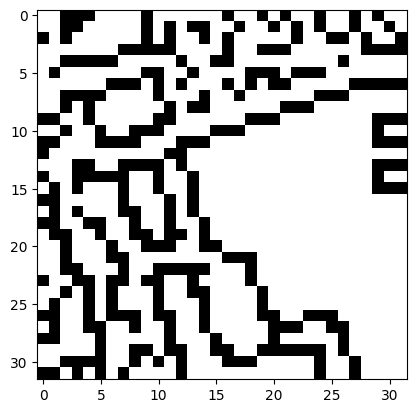

In [49]:
gray = cv.cvtColor(np.array(patches_2[120].patch), cv.COLOR_RGB2GRAY)
gray = cv.GaussianBlur(gray, (3,3), 0)
edges = cv.Canny(gray, 50, 150)

fig, ax = plt.subplots()
ax.imshow(edges, cmap = "gray_r")
plt.show()

In [19]:
patches_1 = MapPatch.get_map_patch_list(file_name = "../src/data/originals/32/82877433.png", 
                                        patch_width = 32, 
                                        verbose = True)
patches_2 = MapPatch.get_map_patch_list(file_name = "../src/data/originals/32/82877436.png", 
                                        patch_width = 32, 
                                        verbose = True)

29-01-2023 18:30:05 INFO 9,322 patches from ../src/data/originals/32/82877433.png generated with shape (79, 118, 1, 32, 32, 3)
29-01-2023 18:30:06 INFO 9,401 patches from ../src/data/originals/32/82877436.png generated with shape (79, 119, 1, 32, 32, 3)


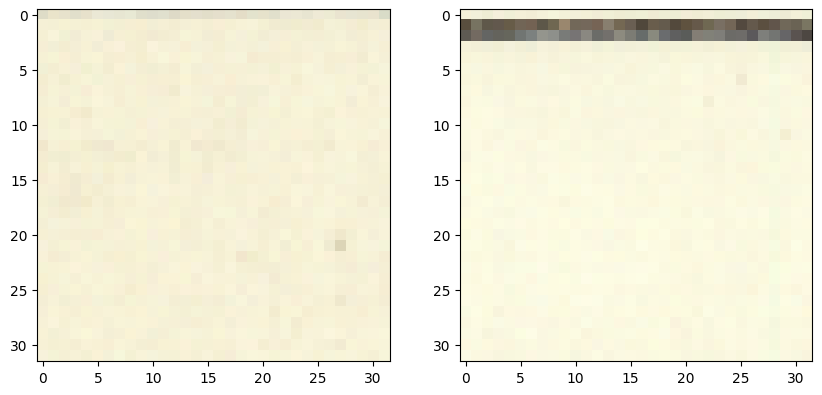

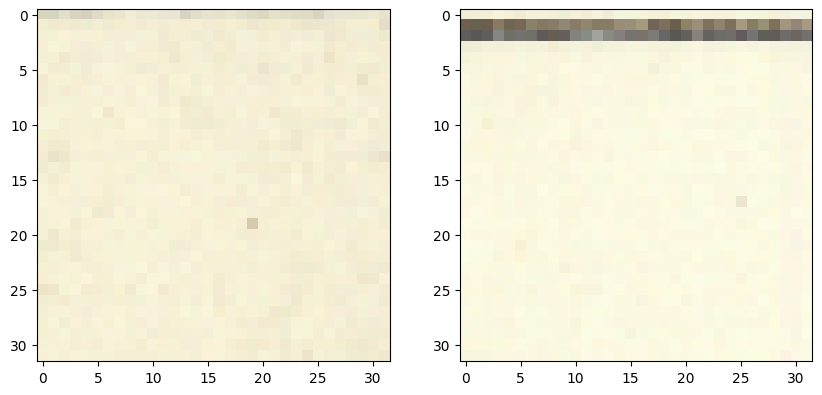

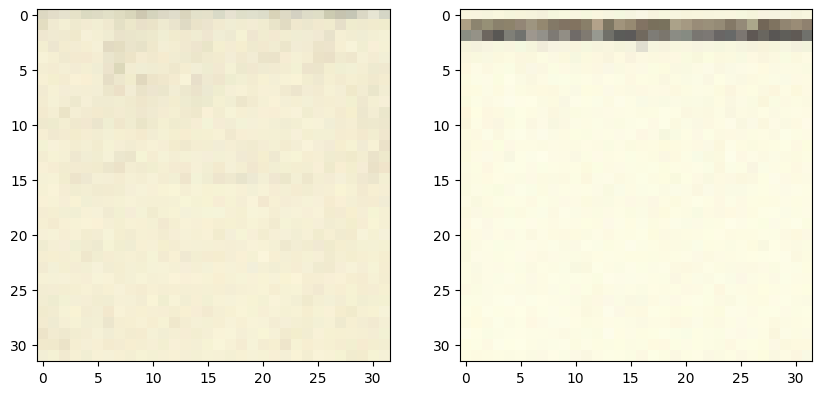

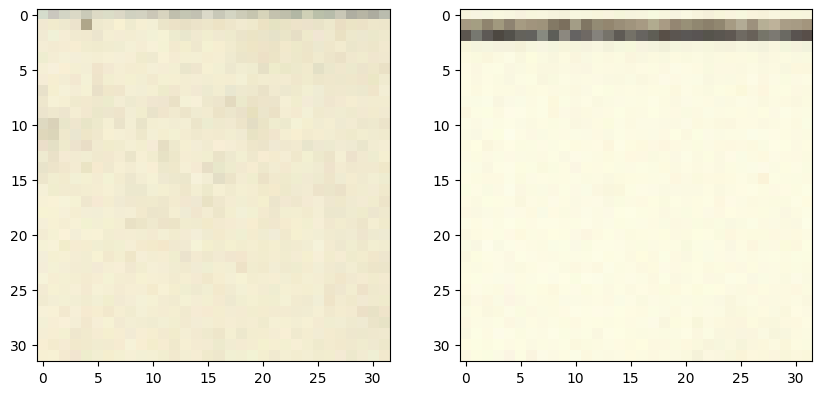

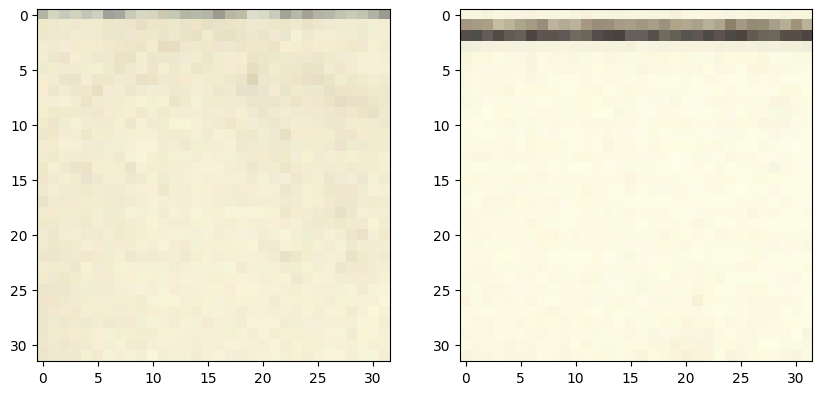

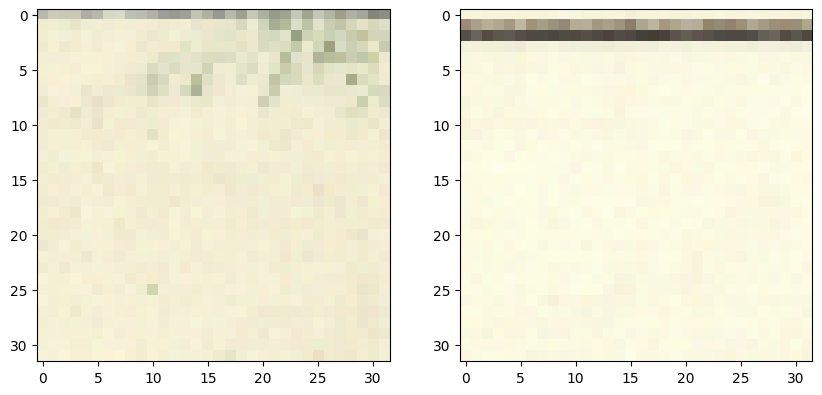

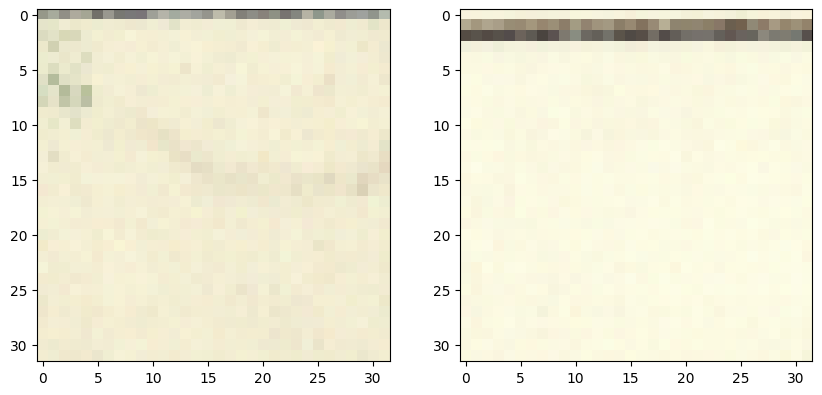

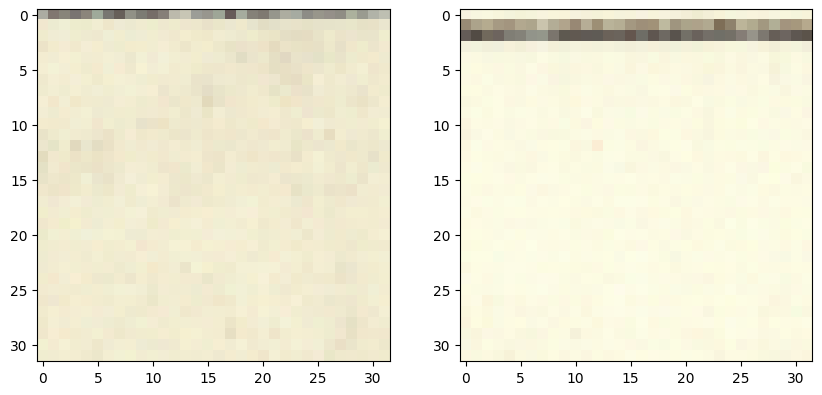

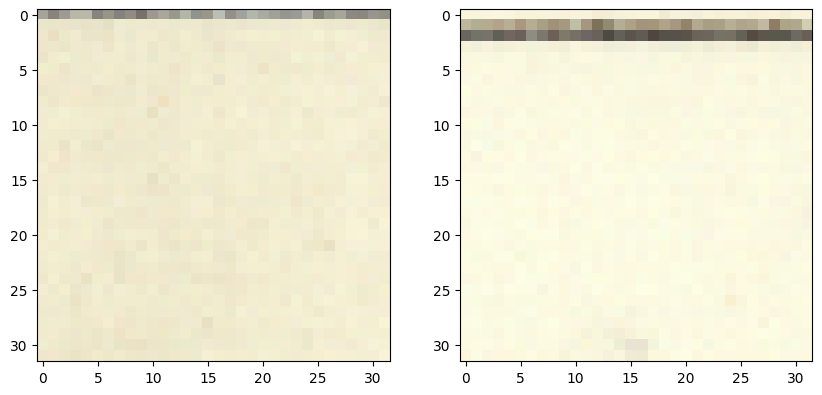

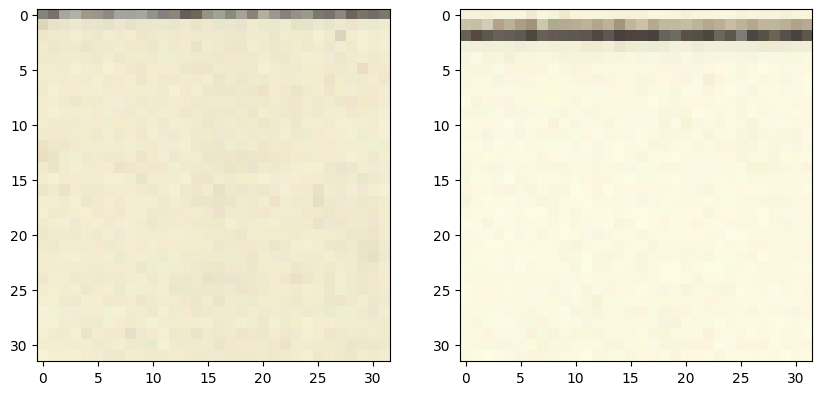

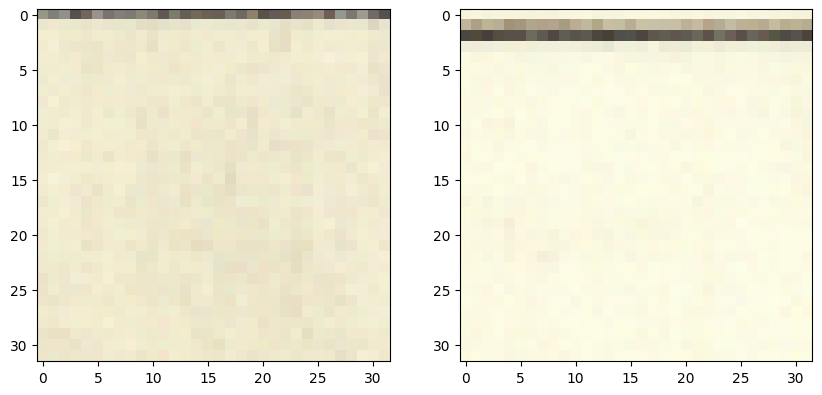

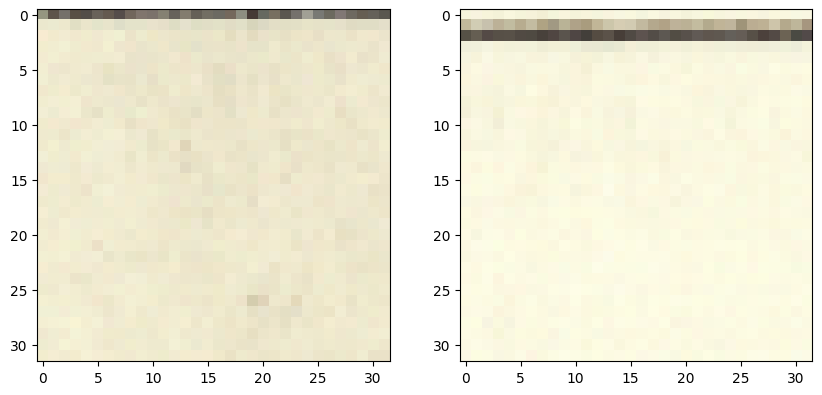

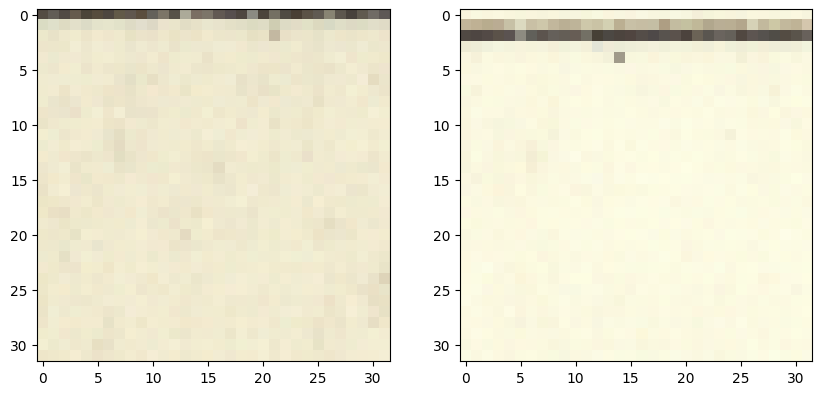

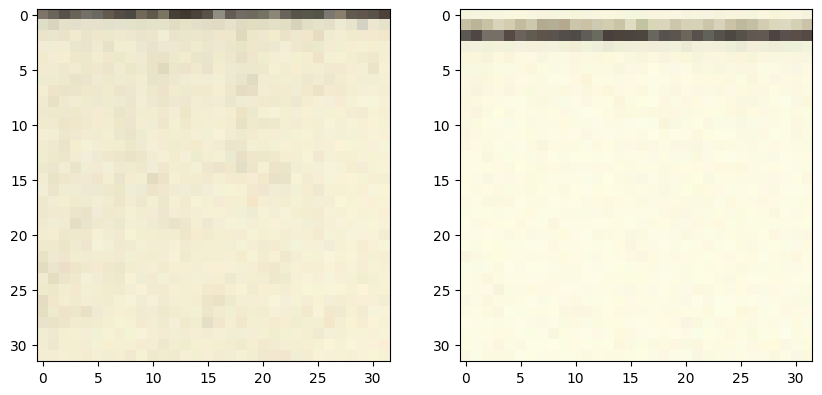

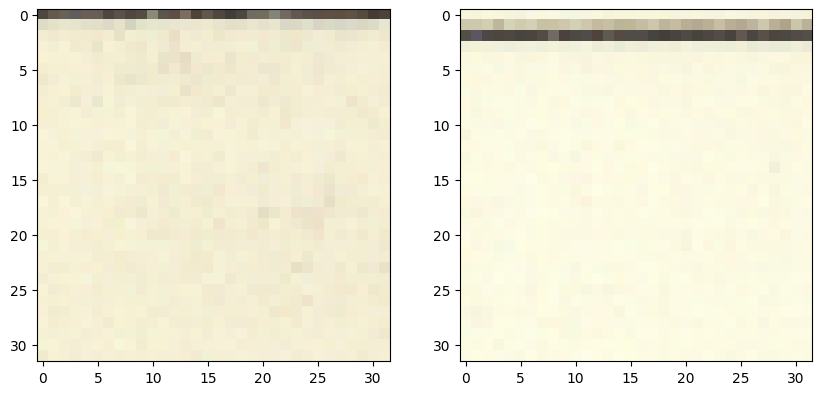

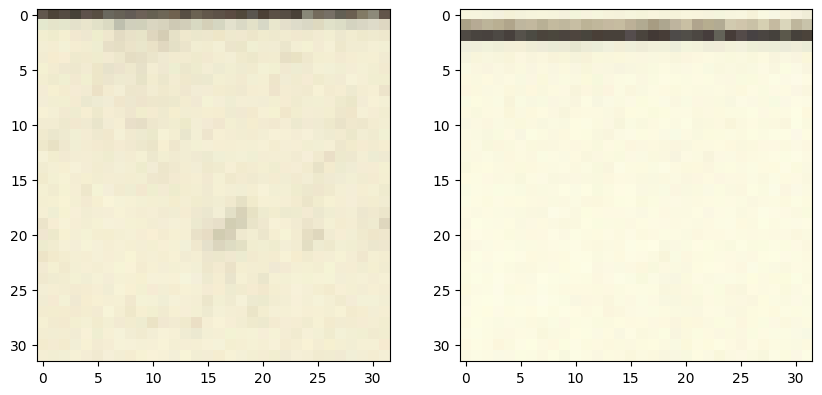

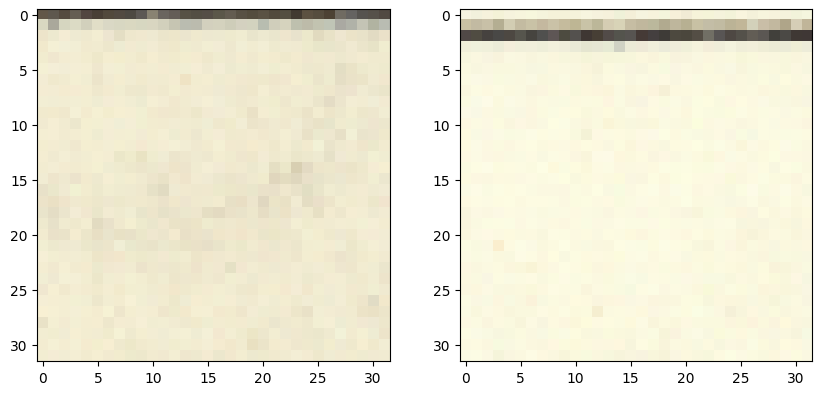

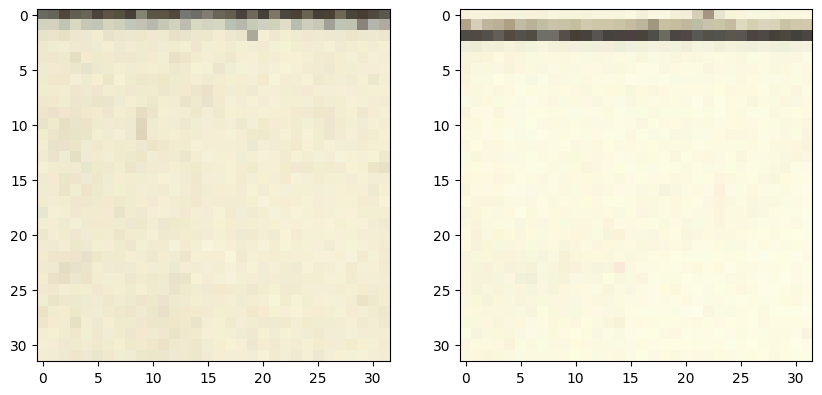

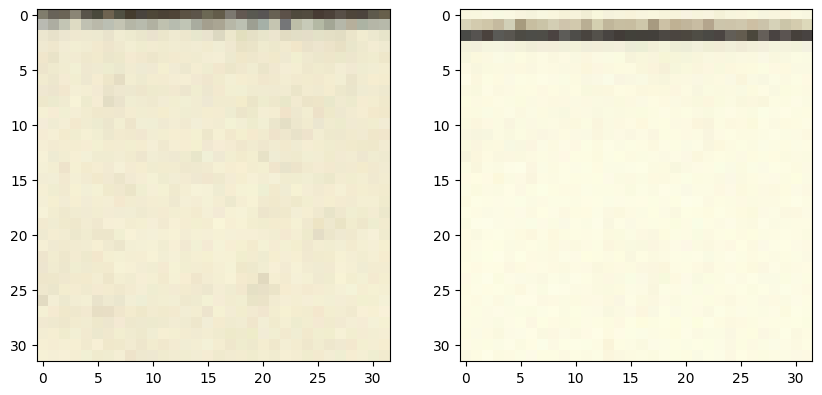

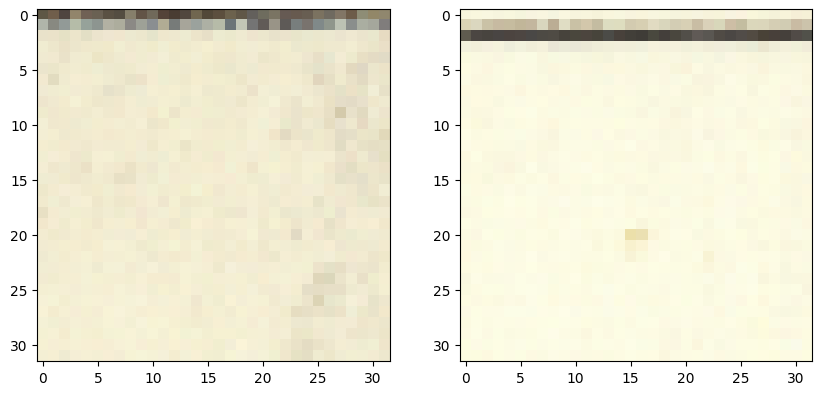

In [28]:
show_patch_pairs(zip(patches_1[50:70], patches_2[50:70]))

In [56]:
cl_patch_dataset = CLPatchDataset.from_dir("../src/data/originals", 32, verbose = True)

29-01-2023 18:57:38 INFO Directories found: ['.DS_Store', '1', '10', '11b', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27b', '28b', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '6', '7', '8', '9']
29-01-2023 18:57:38 INFO Files in first directory: ['.DS_Store', '82877316.png', '82877319.png', '82877322.png']
29-01-2023 18:57:38 INFO Fetching patches from folder: 50
29-01-2023 18:57:50 INFO Fetching patches from folder: 57
29-01-2023 18:57:53 ERROR Found different patch list lengths: {9401, 9322}. Patches won't be added to the dataset.
29-01-2023 18:57:53 INFO Fetching patches from folder: 32
29-01-2023 18:57:56 ERROR Found different patch list lengths: {9401, 9322}. Patches won't be added to the dataset.
29-01-2023 18:57:56 INFO Fetching patches from folder: 35
29-01-2023 18:58:02 ERROR Found

In [58]:
cl_patch_dataset_64 = CLPatchDataset.from_dir("../src/data/originals", 64, verbose = True)

29-01-2023 19:35:32 INFO Directories found: ['.DS_Store', '1', '10', '11b', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27b', '28b', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '6', '7', '8', '9']
29-01-2023 19:35:32 INFO Files in first directory: ['.DS_Store', '82877316.png', '82877319.png', '82877322.png']
29-01-2023 19:35:32 INFO Fetching patches from folder: 50
29-01-2023 19:35:38 INFO Fetching patches from folder: 57
29-01-2023 19:35:43 INFO Fetching patches from folder: 32
29-01-2023 19:36:01 INFO Fetching patches from folder: 35
29-01-2023 19:36:27 INFO Fetching patches from folder: 56
29-01-2023 19:36:42 INFO Fetching patches from folder: 51
29-01-2023 19:36:51 INFO Fetching patches from folder: 34
29-01-2023 19:37:06 INFO Fetching patches from folder: 33
29-01-2023 19:37:22 INFO Fetc

In [3]:
cl_patch_dataset_128 = CLPatchDataset.from_dir("../src/data/originals", 128, verbose = True)

29-01-2023 19:57:57 INFO Directories found: ['.DS_Store', '1', '10', '11b', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27b', '28b', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '6', '7', '8', '9']
29-01-2023 19:57:57 INFO Files in first directory: ['.DS_Store', '82877316.png', '82877319.png', '82877322.png']
29-01-2023 19:57:57 INFO Fetching patches from folder: 50
29-01-2023 19:58:01 INFO Fetching patches from folder: 57
29-01-2023 19:58:04 INFO Fetching patches from folder: 32
29-01-2023 19:58:12 INFO Fetching patches from folder: 35
29-01-2023 19:58:18 INFO Fetching patches from folder: 56
29-01-2023 19:58:22 INFO Fetching patches from folder: 51
29-01-2023 19:58:26 INFO Fetching patches from folder: 34
29-01-2023 19:58:32 INFO Fetching patches from folder: 33
29-01-2023 19:58:39 INFO Fetc

In [57]:
len(cl_patch_dataset)

804754

In [ ]:
cl_patch_loader = DataLoader(cl_patch_dataset, batch_size = 50, shuffle = True)

In [ ]:
first_batch = next(iter(cl_patch_loader))
patches = [(first_batch[0][i], first_batch[1][i]) for i in range(len(first_batch[0]))]
show_patch_pairs(patches)